In [8]:
# 导入需要的包
import numpy as np
#数据处理部分之前的代码，加入部分数据处理的库
import os
import random
import pandas as pd
from collections import deque
import time
import serial
import threading
import pyautogui
import keyboard
import sys
import traceback

#定义从哪个串口中收集
ser = serial.Serial( #下面这些参数根据情况修改
    port='COM3',
    baudrate=115200,
#     baudrate=1200,
    parity=serial.PARITY_ODD,
    stopbits=serial.STOPBITS_TWO,
    bytesize=serial.SEVENBITS
)
dataList = deque(maxlen=100)

#加到fifo队列中
def addToList():
    last_row = ['0','0','0','0','0']
    try:
        while True:
            data = ser.readline().decode().strip().split('\t')
            #消除寄存器溢出产生的全零
            if set(['0','0','0','0','0'])<set(data):
                data = last_row
            dataList.append(data)
            last_row = data
    except:
        ser.close()
        print("ser closed")

#开始收集
t1 = threading.Thread(target=addToList)
t1.start()

In [9]:
#查看数据
x_data = dataList[-1]
x_data

['54.58',
 '15.75',
 '974',
 '-5181',
 '-2302',
 '55.55',
 '14.22',
 '-10540',
 '-6268',
 '1160',
 '-20.22',
 '-36.84',
 '15',
 '39',
 '-77']

In [5]:
#收集的数据会有延迟 按下按键的瞬间不会立即传到数组中
#经测试3个mpu每轮数据输出的间隔时间为17ms 我们等待0.3秒 让数据填充到数组中
#先人工分析哪些数据是需要采集的  看角度的变化会比较好看一点 然后再看加速度变化 大体确定合适的范围
#但是数据流的传输有时候是不稳定的 可能受程序运行速度等各种因素影响 
#我们在延后时间输出的同时 最好自己找到符合特征的数据范围 可能偏上一点也可能偏下一点

row_num = 20  #需要抽取的行数

# dir_path = "3mpu_data/train" #训练集存储的路径
dir_path = "3mpu_data/valid" #验证集存储的路径

file_num = 1
#这里存每次按键的值
f_record = open(dir_path  +  '/key.txt','w+')

#该函数会找到最匹配手指按下的行数区域 并输出到文件中
def writeDataTofile(x,label):
    global file_num
    time.sleep(0.6)
    print(x.name + ' ' + str(file_num))
    if x.name=='u' or x.name=='j' or x.name=='m':
        acc_index = [7,8,9]
    if x.name=='i' or x.name=='k' or x.name==',':
        acc_index = [12,13,14]

    #找到缓存列表中精确的采集范围 用加速度绝对值最大的那几行作为标定点
    index = 0 #加速度绝对值最大的哪一行索引
    avg_acc = 0 #当前计算的平均加速度绝对值
    avg_acc_max = 0 #最大加速度绝对值
    for dataList_i in range(len(dataList)-2):
        #3行一组计算平均加速度绝对值
        #这里拇指 食指 中指 一行采集了15个数据 7，8，9数据是食指的加速度
        row0_1 = abs(float(dataList[dataList_i][acc_index[0]]))
        row0_2 = abs(float(dataList[dataList_i][acc_index[1]]))
        row0_3 = abs(float(dataList[dataList_i][acc_index[2]]))
        row1_1 = abs(float(dataList[dataList_i+1][acc_index[0]]))
        row1_2 = abs(float(dataList[dataList_i+1][acc_index[1]]))
        row1_3 = abs(float(dataList[dataList_i+1][acc_index[2]]))
        row2_1 = abs(float(dataList[dataList_i+2][acc_index[0]]))
        row2_2 = abs(float(dataList[dataList_i+2][acc_index[1]]))
        row2_3 = abs(float(dataList[dataList_i+2][acc_index[2]]))
        row0 = row0_1 + row0_2 + row0_3
        row1 = row1_1 + row1_2 + row1_3
        row2 = row2_1 + row2_2 + row2_3
        avg_acc = (row0+row1+row2)/3
        if avg_acc > avg_acc_max:
            avg_acc_max = avg_acc
            index = dataList_i
    print(str(index)+' '+str(dataList[index][acc_index[0]])+' '\
          +str(dataList[index][acc_index[1]])+' '\
          +str(dataList[index][acc_index[2]])+' ' )

    f_data = open(dir_path + '/data/' + str(file_num) + '.txt','w+')
    for i in range(row_num):
        data_array = ' '.join(list(map(str,dataList[index-15+i]))) #定义了缓存fifo为100行 取index标定的前15行后5行
        f_data.write(data_array)
        f_data.write('\n')
    f_data.flush()

    f_label = open(dir_path + '/label/' + str(file_num) + '.txt','w+')
    label_array = ' '.join(list(map(str,label)))
    f_label.write(label_array)
    f_label.write('\n')
    f_label.flush()
    
    f_record.write(x.name+' ')
    f_record.flush()
    
    file_num += 1

def callback(x):
    try:
        if (x.name == 'u' and x.event_type == 'down'):
            writeDataTofile(x,[1,0,0,0,0,0])
        if (x.name == 'j' and x.event_type == 'down'):
            writeDataTofile(x,[0,1,0,0,0,0])
        if (x.name == 'm' and x.event_type == 'down'):
            writeDataTofile(x,[0,0,1,0,0,0])
        if (x.name == 'i' and x.event_type == 'down'):
            writeDataTofile(x,[0,0,0,1,0,0])
        if (x.name == 'k' and x.event_type == 'down'):
            writeDataTofile(x,[0,0,0,0,1,0])
        if (x.name == ',' and x.event_type == 'down'):
            writeDataTofile(x,[0,0,0,0,0,1])            
    except Exception as e:
        print("导出文本数据错误")
        traceback.print_exc()
        
def record_data():
    keyboard.hook(callback)
    keyboard.wait()
#启动线程
t2 = threading.Thread(target=record_data)
t2.start()

u 1
88 2068 2473 -2816 
u 2
74 561 525 -2059 
u 3
68 400 -2052 406 
j 4
65 705 1375 -1988 
j 5
71 1423 1220 -2038 
j 6
78 1140 1356 -1832 
m 7
63 1434 2493 -1473 
m 8
69 1748 3736 -1601 
m 9
76 -987 488 511 
i 10
73 612 1523 -2278 
i 11
80 869 1747 -3718 
i 12
63 158 831 -1599 
k 13
70 188 1432 -1212 
k 14
76 830 3123 -2819 
k 15
60 621 2571 -2732 
, 16
66 -95 2509 -542 
, 17
74 885 4213 -854 
, 18
72 -478 1158 -928 
u 19
60 283 976 -1147 
u 20
68 2143 1445 -3033 
u 21
73 924 1206 -2415 
j 22
79 2860 3160 -4606 
j 23
61 2057 2257 -3323 
j 24
65 417 1081 -1270 
m 25
71 1769 3435 -1359 
m 26
76 1619 3266 -1764 
m 27
74 1514 1133 -2426 
i 28
71 276 1643 -2309 
i 29
77 824 1919 -3448 
i 30
60 781 2070 -3210 
k 31
64 662 2477 -2147 
k 32
70 214 1732 -1394 
k 33
75 956 3884 -3404 
, 34
61 830 5561 -1587 
, 35
67 -135 3038 -640 
, 36
72 375 3861 -422 
i 37
78 587 1979 -1963 
i 38
62 560 1772 -2705 
i 39
66 516 1167 -2580 
m 40
78 1621 1394 -2181 
m 41
68 1956 4794 -2114 
m 42
72 1242 3130 -84

uuujjjmmmiiikkk,,,uuujjjmmmiiikkk,,,iiimmm,,,uuukkkjjjuuu,,,iiimmmkkkjjjuuuiiikkk,,,mmmjjjiiimmm,,,

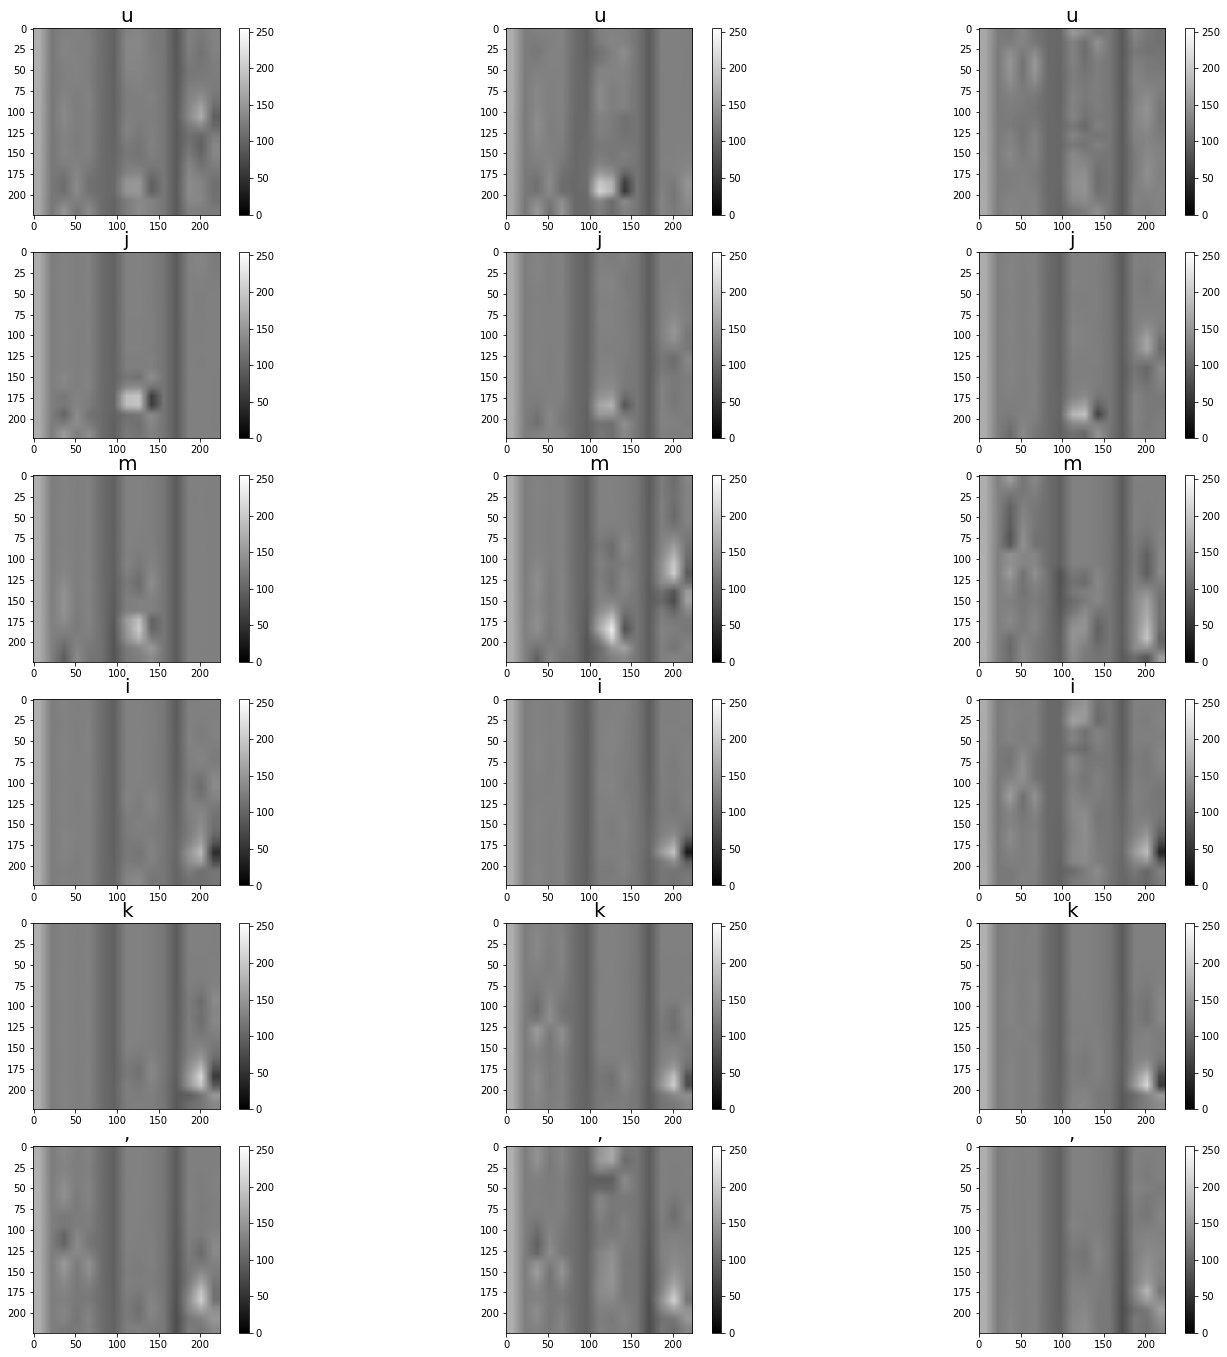

In [39]:

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import random
%matplotlib inline
from PIL import Image

#读取数据文件 可视化成图像
data_dir = '3mpu_data/train'
degree = 360
acc = 32768
# acc = 16384
def readFileToNparray(fileName):
    
    dataList = []
    #文件数据读取成list
    with open(data_dir + '/data/' + str(fileName),'r') as f:
        for line in f.readlines():      
            data = list(map(float,line.strip().split(' ')))
            dataList.append(data)
    #数据转成像素范围内的数值 0-255
    for line in dataList:
        line[0] = (line[0]+degree/2)*255/degree
        line[1] = (line[1]+degree/2)*255/degree
        line[5] = (line[5]+degree/2)*255/degree
        line[6] = (line[6]+degree/2)*255/degree
        line[10] = (line[10]+degree/2)*255/degree
        line[11] = (line[11]+degree/2)*255/degree

        line[2] = (line[2] + acc/2)*255/acc
        line[3] = (line[3] + acc/2)*255/acc
        line[4] = (line[4] + acc/2)*255/acc
        line[7] = (line[7] + acc/2)*255/acc
        line[8] = (line[8] + acc/2)*255/acc
        line[9] = (line[9] + acc/2)*255/acc
        line[12] = (line[12] + acc/2)*255/acc
        line[13] = (line[13] + acc/2)*255/acc
        line[14] = (line[14] + acc/2)*255/acc

    return np.array(dataList)

# 画出读取的图片
img_num = 18
img_start = 18 #从0开始
cols = 3
rows = img_num/cols

# hot 从黑平滑过度到红、橙色和黄色的背景色，然后到白色。
# cool 包含青绿色和品红色的阴影色。从青绿色平滑变化到品红色。
# gray 返回线性灰度色图。
# bone 具有较高的蓝色成分的灰度色图。该色图用于对灰度图添加电子的视图。
# white 全白的单色色图。 
# spring 包含品红和黄的阴影颜色。 
# summer 包含绿和黄的阴影颜色。
# autumn 从红色平滑变化到橙色，然后到黄色。 
# winter 包含蓝和绿的阴影色。


def drawImg(i,title,fileName):
    f = plt.subplot(rows,cols,i+1-img_start)
    f.set_title(title, fontsize=20)
    plt.imshow(cv2.resize(readFileToNparray(fileName), (224, 224)),cmap='gray',vmin=0,vmax=255)
#     plt.imshow(cv2.resize(readFileToNparray(fileName), (224, 224)),cmap=cm.hot,vmin=20,vmax=150)
    plt.colorbar()

data_list = []
with open(data_dir + '/key.txt','r') as f:
    data_list = f.readline().strip().split(' ')
    
plt.figure(figsize=(24, 24))

#画图
for i in range(img_start,img_start+img_num):
    fileName = str(i+1) + '.txt'
    drawImg(i,data_list[i],fileName)
    
plt.show()

In [5]:
ser.close()

ser closed


In [3]:
#构造神经网络 使用现成的LeNet 稍加改造以适应数据维度
# 导入需要的包
import paddle
import paddle.fluid as fluid
import numpy as np
from paddle.fluid.layer_helper import LayerHelper
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, BatchNorm, FC
from paddle.fluid.dygraph.base import to_variable


# 定义 LeNet 网络结构
class myLeNet(fluid.dygraph.Layer):
    def __init__(self, name_scope, num_classes=6):
        super(myLeNet, self).__init__(name_scope)
        name_scope = self.full_name()
        # 创建卷积和池化层块，每个卷积层使用Sigmoid激活函数，后面跟着一个2x2的池化
        self.conv1 = Conv2D(name_scope, num_filters=64, filter_size=3, act='sigmoid')
        self.pool1 = Pool2D(name_scope, pool_size=3, pool_stride=2, pool_type='max')
        self.conv2 = Conv2D(name_scope, num_filters=32, filter_size=3, act='sigmoid')
        self.pool2 = Pool2D(name_scope, pool_size=3, pool_stride=2, pool_type='max')
#         # 创建第3个卷积层
        self.conv3 = Conv2D(name_scope, num_filters=32, filter_size=3, act='sigmoid')
#         创建全连接层，第一个全连接层的输出神经元个数为64， 第二个全连接层输出神经元个数为分裂标签的类别数
        self.fc1 = FC(name_scope, size=64, act='sigmoid')
        self.fc2 = FC(name_scope, size=num_classes)
        
    # 网络的前向计算过程
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    


In [2]:
#将数据转成图片像素范围
def rawToPicture(rawData):
    for line in rawData:
        line[0] = (line[0]+180)*255/360
        line[1] = (line[1]+180)*255/360
        line[5] = (line[5]+180)*255/360
        line[6] = (line[6]+180)*255/360
        line[10] = (line[10]+180)*255/360
        line[11] = (line[11]+180)*255/360

        line[2] = (line[2] + 16384)*255/32768
        line[3] = (line[3] + 16384)*255/32768
        line[4] = (line[4] + 16384)*255/32768
        line[7] = (line[7] + 16384)*255/32768
        line[8] = (line[8] + 16384)*255/32768
        line[9] = (line[9] + 16384)*255/32768
        line[12] = (line[12] + 16384)*255/32768
        line[13] = (line[13] + 16384)*255/32768
        line[14] = (line[14] + 16384)*255/32768
    return np.array(rawData) 

In [3]:
#从txt文件中读取数据 并转成符合神经网络的格式

# 定义数据读取器
def data_loader(datadir, batch_size=3, mode = 'train'):
    # 将datadir目录下的文件列出来，每条文件都要读入
    if mode == 'train':
        datadir = datadir + '/train'
    if mode == 'valid':
        datadir = datadir + '/valid'
        
    filenames_data = os.listdir(datadir + '/data')
    filenames_label = os.listdir(datadir + '/label')
    def reader():
        if mode == 'train':
            # 训练时随机打乱数据顺序
            random.shuffle(filenames_data)
        batch_imgs = []
        batch_labels = []
        for name in filenames_data:
            filepath_data = os.path.join(datadir+'/data', name)
            filepath_label = os.path.join(datadir+'/label',name)
#             pdb.set_trace()
            img = []
            label = []
            with open(filepath_data,'r') as f_data:
                for line in f_data.readlines():      
                    data_line = list(map(float,line.strip().split(' ')))
                    img.append(data_line)
            img = rawToPicture(img) #将数据调整到图片像素范围
            img = cv2.resize(np.array(img), (224, 224)) #将数据扩大
#             pdb.set_trace()
            with open(filepath_label,'r') as f_label:
                label = f_label.readline().strip().split(' ')
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
#                 imgs_array = np.array(batch_imgs).astype('float32').reshape(-1,1,20,15)
                imgs_array = np.array(batch_imgs).astype('float32').reshape(-1,1,224,224)
                labels_array = np.array(batch_labels).astype('float32').reshape(-1,6)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
#             imgs_array = np.array(batch_imgs).astype('float32').reshape(-1,1,20,15)
            imgs_array = np.array(batch_imgs).astype('float32').reshape(-1,1,224,224)
            labels_array = np.array(batch_labels).astype('float32').reshape(-1,6)
            yield imgs_array, labels_array

    return reader


In [4]:
# 查看数据形状
DATADIR = '3mpu_data'
train_loader = data_loader(DATADIR, batch_size=3, mode='train')
data_reader = train_loader()


In [5]:
data = next(data_reader)
data[0].shape, data[1].astype('int64')


((3, 1, 224, 224),
 array([[0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0]], dtype=int64))

In [28]:
# -*- coding: utf-8 -*-

# LeNet 识别手势输入模型

import os
import random
import paddle
import paddle.fluid as fluid
import numpy as np
import pdb

DATADIR = '3mpu_data' #路径

# 定义训练过程
def train(model):
    with fluid.dygraph.guard():
        print('start training ... ')
        model.train()
        epoch_num = 1
        # 定义优化器
        opt = fluid.optimizer.Momentum(learning_rate=0.0001, momentum=0.9)
        # 定义数据读取器，训练数据读取器和验证数据读取器
        train_loader = data_loader(DATADIR, batch_size=3, mode='train')
        valid_loader = data_loader(DATADIR, batch_size=3, mode='valid')
        for epoch in range(epoch_num):
            for batch_id, data in enumerate(train_loader()):
                x_data, y_data = data
                pdb.set_trace()
                img = fluid.dygraph.to_variable(x_data)
                label = fluid.dygraph.to_variable(y_data)
                # 运行模型前向计算，得到预测值
                logits = model(img)
#                 pred = fluid.layers.softmax(logits)
                # 进行loss计算
                loss = fluid.layers.sigmoid_cross_entropy_with_logits(logits, label)
                avg_loss = fluid.layers.mean(loss)
#                 pdb.set_trace()
                if batch_id % 3 == 0:
                    print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
                # 反向传播，更新权重，清除梯度
                avg_loss.backward()
                opt.minimize(avg_loss)
                model.clear_gradients()

            model.eval()
            accuracies = []
            losses = []
            for batch_id, data in enumerate(valid_loader()):
                x_data, y_data = data
                img = fluid.dygraph.to_variable(x_data)
                label = fluid.dygraph.to_variable(y_data)
                # 运行模型前向计算，得到预测值
                logits = model(img)
                pred = fluid.layers.softmax(logits)
                loss = fluid.layers.sigmoid_cross_entropy_with_logits(logits, label)
#                 pdb.set_trace()
                acc = fluid.layers.accuracy(paddle.fluid.layers.reshape(pred,shape=[-1,1]), paddle.fluid.layers.reshape(label.astype('int64'),shape=[-1,1]))
                accuracies.append(acc.numpy())
                losses.append(loss.numpy())
            print("[validation] accuracy/loss: {}/{}".format(np.mean(accuracies), np.mean(losses)))
            model.train()

        # save params of model
        fluid.save_dygraph(model.state_dict(), '3mpu')
        # save optimizer state
        fluid.save_dygraph(opt.state_dict(), '3mpu')




In [8]:
if __name__ == '__main__':
    # 创建模型
    with fluid.dygraph.guard():
        model = myLeNet("myLeNet", num_classes=6)

    train(model)

start training ... 
epoch: 0, batch_id: 0, loss is: [0.6637523]
epoch: 0, batch_id: 3, loss is: [0.5913074]
epoch: 0, batch_id: 6, loss is: [0.46619543]
epoch: 0, batch_id: 9, loss is: [0.5587137]
epoch: 0, batch_id: 12, loss is: [0.5196045]
epoch: 0, batch_id: 15, loss is: [0.4618855]
epoch: 0, batch_id: 18, loss is: [0.44557413]
epoch: 0, batch_id: 21, loss is: [0.49980867]
epoch: 0, batch_id: 24, loss is: [0.38809997]
epoch: 0, batch_id: 27, loss is: [0.4574138]
epoch: 0, batch_id: 30, loss is: [0.50383687]
epoch: 0, batch_id: 33, loss is: [0.4729706]
epoch: 0, batch_id: 36, loss is: [0.49266875]
epoch: 0, batch_id: 39, loss is: [0.43569997]
epoch: 0, batch_id: 42, loss is: [0.45502615]
epoch: 0, batch_id: 45, loss is: [0.5078502]
epoch: 0, batch_id: 48, loss is: [0.46065128]
epoch: 0, batch_id: 51, loss is: [0.45118618]
epoch: 0, batch_id: 54, loss is: [0.46279728]
epoch: 0, batch_id: 57, loss is: [0.47305906]
epoch: 0, batch_id: 60, loss is: [0.42897993]
epoch: 0, batch_id: 63, lo

In [19]:
#测试
with fluid.dygraph.guard():
    model = myLeNet("myLeNet", num_classes=6)

    model_state_dict, _ = fluid.load_dygraph('3mpu')
    model.load_dict(model_state_dict)
    model.eval()
    train_loader = data_loader(DATADIR, batch_size=1, mode='valid')
    x_data,y_data = next(train_loader())
    img = fluid.dygraph.to_variable(x_data)
#     pdb.set_trace()
    prediction = model(img)
    pred = fluid.layers.softmax(prediction)
    print(pred)
    print(y_data)

name tmp_16, dtype: VarType.FP32 shape: [1, 6] 	lod: {}
	dim: 1, 6
	layout: NCHW
	dtype: float
	data: [0.146573 0.255309 0.157512 0.084663 0.167144 0.188799]

[[1. 0. 0. 0. 0. 0.]]


In [29]:
#用LeNet网络训练不收敛 用AlexNet试试

# -*- coding:utf-8 -*-

# 导入需要的包
import paddle
import paddle.fluid as fluid
import numpy as np
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, FC


# 定义 AlexNet 网络结构
class AlexNet(fluid.dygraph.Layer):
    def __init__(self, name_scope, num_classes=6):
        super(AlexNet, self).__init__(name_scope)
        name_scope = self.full_name()
        # AlexNet与LeNet一样也会同时使用卷积和池化层提取图像特征
        # 与LeNet不同的是激活函数换成了‘relu’
        self.conv1 = Conv2D(name_scope, num_filters=96, filter_size=11, stride=4, padding=5, act='relu')
        self.pool1 = Pool2D(name_scope, pool_size=2, pool_stride=2, pool_type='max')
        self.conv2 = Conv2D(name_scope, num_filters=256, filter_size=5, stride=1, padding=2, act='relu')
        self.pool2 = Pool2D(name_scope, pool_size=2, pool_stride=2, pool_type='max')
        self.conv3 = Conv2D(name_scope, num_filters=384, filter_size=3, stride=1, padding=1, act='relu')
        self.conv4 = Conv2D(name_scope, num_filters=384, filter_size=3, stride=1, padding=1, act='relu')
        self.conv5 = Conv2D(name_scope, num_filters=256, filter_size=3, stride=1, padding=1, act='relu')
        self.pool5 = Pool2D(name_scope, pool_size=2, pool_stride=2, pool_type='max')

        self.fc1 = FC(name_scope, size=4096, act='relu')
        self.drop_ratio1 = 0.5
        self.fc2 = FC(name_scope, size=4096, act='relu')
        self.drop_ratio2 = 0.5
        self.fc3 = FC(name_scope, size=num_classes)

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool5(x)

        x = self.fc1(x)
        # 在全连接之后使用dropout抑制过拟合
        x= fluid.layers.dropout(x, self.drop_ratio1)
        x = self.fc2(x)
        # 在全连接之后使用dropout抑制过拟合
        x = fluid.layers.dropout(x, self.drop_ratio2)
        x = self.fc3(x)
        return x


In [30]:

with fluid.dygraph.guard():
    model = AlexNet("AlexNet")

train(model)

start training ... 
> <ipython-input-28-a9f0d3a0ad69>(29)train()
-> img = fluid.dygraph.to_variable(x_data)
(Pdb) y_data
array([[0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)
(Pdb) c
epoch: 0, batch_id: 0, loss is: [43.20109]
> <ipython-input-28-a9f0d3a0ad69>(28)train()
-> pdb.set_trace()
(Pdb) y_data
array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)
(Pdb) c
> <ipython-input-28-a9f0d3a0ad69>(29)train()
-> img = fluid.dygraph.to_variable(x_data)
(Pdb) y_data
array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)
(Pdb) q


BdbQuit: 

In [37]:
train_loader = data_loader(DATADIR, batch_size=6, mode='valid')

In [38]:
#测试
with fluid.dygraph.guard():
    model = AlexNet("AlexNet", num_classes=6)

    model_state_dict, _ = fluid.load_dygraph('3mpu')
    model.load_dict(model_state_dict)
    model.eval()
    
    x_data,y_data = next(train_loader())
#     pdb.set_trace()
    img = fluid.dygraph.to_variable(x_data)
#     pdb.set_trace()
    prediction = model(img)
    pred = fluid.layers.softmax(prediction)
    print(pred)
    print(y_data)

name tmp_30, dtype: VarType.FP32 shape: [6, 6] 	lod: {}
	dim: 6, 6
	layout: NCHW
	dtype: float
	data: [0.239142 0.112722 0.200829 0.212652 0.126028 0.108627 0.237157 0.108912 0.196378 0.211326 0.140178 0.106049 0.242798 0.106807 0.190155 0.210879 0.14076 0.108601 0.242804 0.106191 0.197749 0.2121 0.134269 0.106886 0.242205 0.107308 0.191211 0.211975 0.136379 0.11092 0.241991 0.105072 0.187039 0.21583 0.142903 0.107165]

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]
